In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


### Load and inspect data

   stationId                Stationsnavn  Northings  Eastings  Højde
2       5025  FREDERIKSHAVN_MATERIELGÅRD    6368352    589564   18.0


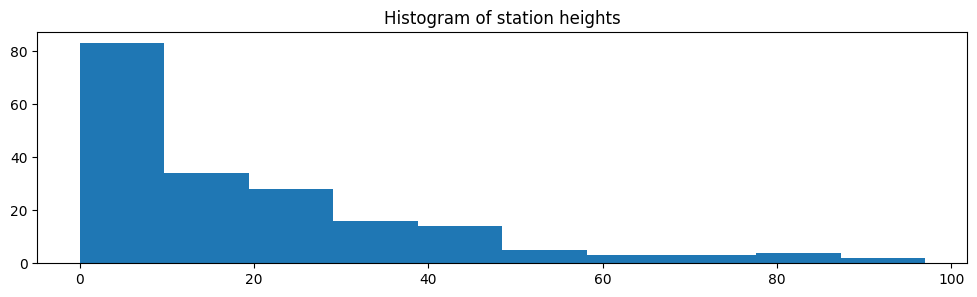

In [2]:
# Load meta data
station_path = 'C:/Users/lissn/Thesis/data/meta_data/SVK_stationsliste.txt' 
station_df = pd.read_csv(station_path,  sep=' ', index_col=False)
station_df.rename(columns={'05Nr': 'stationId'}, inplace=True)
station_df = station_df[station_df['Slutdato'].isna()] # Only keep active stations
station_df = station_df[['stationId', 'Stationsnavn', 'Northings', 'Eastings', 'Højde' ]]
print(station_df.head(1))

plt.figure(figsize=(12, 3))
plt.hist(station_df['Højde'])
plt.title('Histogram of station heights')
plt.show()

In [3]:
# Load 2023 SVK data
SVK_path = 'C:/Users/lissn/Thesis/data/2023_rain_observations.csv'
df = pd.read_csv(SVK_path)
df['time'] = pd.to_datetime(df['time'])
df = df.set_index(df.columns[0])

In [4]:
total_values = df.size
zero_counts = (df == 0).sum().sum()
nan_counts = df.isna().sum().sum()
positive_counts = (df > 0).sum().sum()

# Calculate percentages
percent_zero = (zero_counts / total_values) * 100
percent_nan = (nan_counts / total_values) * 100  
percent_positive = (positive_counts / total_values) * 100

print(f"Percentage of 0 values: {percent_zero:.2f}%")
print(f"Percentage of NaN values: {percent_nan:.2f}%")
print(f"Percentage of positive values: {percent_positive:.2f}%")

Percentage of 0 values: 97.25%
Percentage of NaN values: 0.56%
Percentage of positive values: 2.19%


### Data Preprocessing


#### Standardize

In [5]:
# Calculate the overall mean and standard deviation
overall_mean = np.nanmean(df.values.flatten())
overall_std = np.nanstd(df.values.flatten())

# Apply standardization formula
df_standardized = (df - overall_mean) / overall_std

### Aligning Radar Data with Gauge Locations


In [6]:
from pyproj import Transformer
from pyproj import CRS

# Radar coordinates
x_radar_coords = np.arange(-421364.8 - 500, 569635.2 + 500, 500) 
y_radar_coords = np.arange(468631 + 500, -394369 - 500, -500)

# Project the radar coordinates into the target CRS
def project_raster_coords(x_coords, y_coords, orig_crs, dest_crs):
    xx, yy = np.meshgrid(x_coords, y_coords)
    transformer = Transformer.from_crs(orig_crs, dest_crs, always_xy = True)
    new_coords = transformer.transform(xx, yy)
    x_new, y_new = new_coords[0], new_coords[1]
    return(x_new, y_new)

dmi_stere_crs = CRS("+proj=stere +ellps=WGS84 +lat_0=56 +lon_0=10.5666 +lat_ts=56") # raw data CRS projection
plotting_crs = 'epsg:4326' # the CRS projection you want to plot the data in
radar_lons, radar_lats = project_raster_coords(x_radar_coords, y_radar_coords, dmi_stere_crs, plotting_crs) 

In [7]:
# Define the transformer: UTM Zone 32N (EUREF89) to WGS84
transformer = Transformer.from_crs('epsg:25832', 'epsg:4326', always_xy=True)

# Transform function
def transform_coordinates(easting, northing):
    lon, lat = transformer.transform(easting, northing)
    return lon, lat

# Correct mistake in data
station_df['Northings'] = station_df['Northings'].apply(lambda x: x / 1e8 if x > 1e9 else x)
station_df['Eastings'] = station_df['Eastings'].apply(lambda x: x / 1e9 if x > 1e9 else x)

# Apply the transformation
station_df['Longitude'], station_df['Latitude'] = zip(*station_df.apply(lambda row: transform_coordinates(row['Eastings'], row['Northings']), axis=1))

# Filter such that only stations with mesured data are included
station_df['stationId_str'] = station_df['stationId'].astype(str)
filtered_station_df = station_df[station_df['stationId_str'].isin(df.columns)]

In [8]:
from scipy.spatial import cKDTree

# Calculate midpoints
def calculate_midpoints(coords):
    # Average with the adjacent (right and bottom) coordinates to find midpoints
    shifted_right = np.roll(coords, shift=-1, axis=1)
    shifted_down = np.roll(coords, shift=-1, axis=0)
    
    # Calculate the average of the current and shifted arrays
    midpoints = (coords + shifted_right + shifted_down + np.roll(shifted_down, shift=-1, axis=1)) / 4
    
    # Exclude the last row and column which don't form complete squares
    return midpoints[:-1, :-1]

# Calculate midpoints for longitude and latitude separately
mid_lons = calculate_midpoints(radar_lons)
mid_lats = calculate_midpoints(radar_lats)

# Prepare the radar points (midpoints of pixels) for KDTree
radar_midpoints = np.column_stack((mid_lons.flatten(), mid_lats.flatten()))

# Build a KDTree for fast nearest-neighbor lookup using radar midpoints
tree = cKDTree(radar_midpoints)

# Convert station locations to an array of (longitude, latitude) pairs for searching
station_points = station_df[['Longitude', 'Latitude']].values

# Find the nearest radar pixel midpoint for each station
distances, indices_1d = tree.query(station_points)

# Translate the 1D indices back to 2D indices in the radar arrays
# Note: We subtract 1 from the shape of the radar arrays because the midpoints grid is smaller
num_cols = radar_lons.shape[1] - 1
indices_row = indices_1d // num_cols
indices_col = indices_1d % num_cols

# Add the indices to station_df
station_df['radar_pixel_row'] = indices_row
station_df['radar_pixel_col'] = indices_col

In [9]:
# Group by radar_pixel_row and radar_pixel_col
grouped = station_df.groupby(['radar_pixel_row', 'radar_pixel_col'])

# Initialize an empty DataFrame to store results
shared_pixel_different_stations = pd.DataFrame()

# Iterate over each group
for _, group in grouped:
    if len(group) > 1 and group['Stationsnavn'].nunique() > 1 and group['Northings'].nunique() > 1 and group['Eastings'].nunique() > 1:
        # The group has more than one element, unique station names, and unique Northings and Eastings
        shared_pixel_different_stations = pd.concat([shared_pixel_different_stations, group])

# shared_pixel_different_stations now contains only the rows from station_df
# where stations share the same radar pixel but have different Stationsnavn, Northings, and Eastings
shared_pixel_different_stations

""


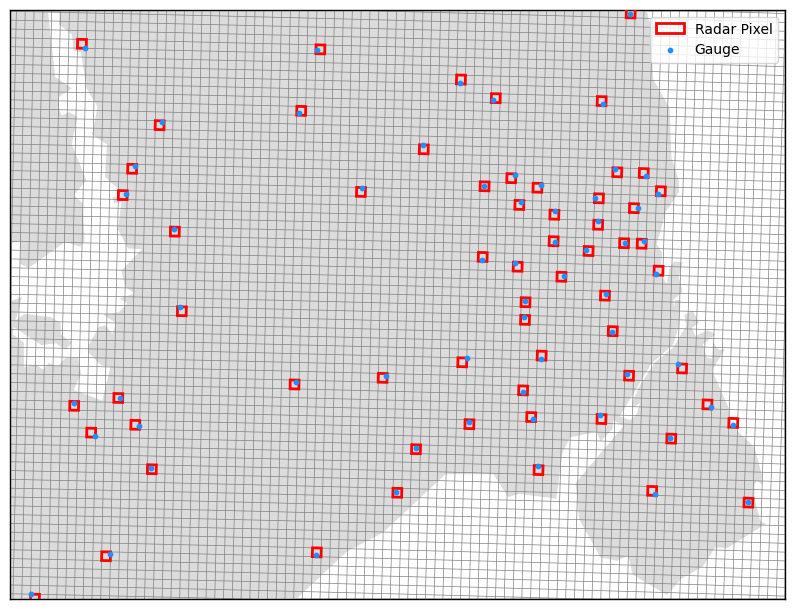

In [32]:
# Create figure
plt.figure(figsize=(10, 10))

# Define latitude and longitude boundaries for Denmark
llcrnrlat = 55.55      # lower latitude
urcrnrlat = 55.85       # upper latitude
llcrnrlon = 12         # lower longitude
urcrnrlon = 12.7       # upper longitude

# Create a Basemap instance
m = Basemap(projection='merc', llcrnrlat=llcrnrlat, urcrnrlat=urcrnrlat, llcrnrlon=llcrnrlon, urcrnrlon=urcrnrlon, lat_ts=0, resolution='h')

# Draw map details
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='gainsboro', lake_color='white')

# Convert lons and lats to x and y for plotting
x, y = m(radar_lons, radar_lats)

# Plot longitude and latitude lines
for col in range(x.shape[1]):
    plt.plot(x[:, col], y[:, col], color='gray', linestyle='-', linewidth=0.5, zorder=1)
for row in range(y.shape[0]):
    plt.plot(x[row, :], y[row, :], color='gray', linestyle='-', linewidth=0.5, zorder=1)

# Initialize a set to keep track of labels already added
added_labels = set()

# Loop through each station in station_df
for idx, row in station_df.iterrows():
    pixel_row = row['radar_pixel_row']
    pixel_col = row['radar_pixel_col']
    
    # Only add label if not added yet
    label = 'Radar Pixel' if 'Radar Pixel' not in added_labels else None
    if label:
        added_labels.add(label)
    
    # Check if pixel_row and pixel_col are valid
    if not np.isnan(pixel_row) and not np.isnan(pixel_col):
        # Plot the pixel as a polygon
        pixel_corners_lon = [radar_lons[int(pixel_row), int(pixel_col)], radar_lons[int(pixel_row), int(pixel_col+1)],
                             radar_lons[int(pixel_row+1), int(pixel_col+1)], radar_lons[int(pixel_row+1), int(pixel_col)],
                             radar_lons[int(pixel_row), int(pixel_col)]]
        pixel_corners_lat = [radar_lats[int(pixel_row), int(pixel_col)], radar_lats[int(pixel_row), int(pixel_col+1)],
                             radar_lats[int(pixel_row+1), int(pixel_col+1)], radar_lats[int(pixel_row+1), int(pixel_col)],
                             radar_lats[int(pixel_row), int(pixel_col)]]
        x_pixel_corners, y_pixel_corners = m(pixel_corners_lon, pixel_corners_lat)
        polygon = plt.Polygon(list(zip(x_pixel_corners, y_pixel_corners)), edgecolor='red', facecolor='none', linewidth=2, zorder=5, label=label)
        plt.gca().add_patch(polygon)

# Plot gauge stations
for idx, row in station_df.iterrows():
    x, y = m(row['Longitude'], row['Latitude'])
    plt.scatter(x, y, marker='o', color='dodgerblue', zorder=10, s=10, label='Gauge' if 'Gauge' not in added_labels else None)
    added_labels.add('Gauge')  # Ensure gauge label is added only once

plt.legend(loc='upper right')
plt.savefig('C:/Users/lissn/Thesis/figures/station_radar_pixel_mapping.png', dpi=300, bbox_inches='tight')
plt.show()
